# Taylor diagram function

In [78]:
import scipy.interpolate as scint

def regridder(model,obs,ovar_name):

    bgc_ovar_names = ['dissic','no3','po4','talk']

    # z distance is much less than distance between stations
    scale_factor = model.dx.mean().values*1e3

    ovar_obs = obs.iloc[0:,2].values.ravel()
    
    stations_obs = obs.station.values.ravel()
    depth_obs = obs.depth.values.ravel()


    stations_model = model.station.values.ravel()
    depth_model = model.lev.values.ravel()

    stations_model,depth_model = np.meshgrid(stations_model,depth_model)

    interpolated_obs = scint.griddata((stations_obs, depth_obs/scale_factor),ovar_obs,
                              (stations_model, depth_model/scale_factor),
                              method='linear')

    interpolated_obs = xr.DataArray(interpolated_obs,dims = model.dims, coords = model.coords,attrs=model[ovar_name].attrs)
    interpolated_obs = interpolated_obs.where(~np.isnan(model[ovar_name]))
    interpolated_obs = interpolated_obs.to_dataset(name=ovar_name)
    
    return interpolated_obs

def glodap_to_model(cruise_id,glodap,coords,expc,ovar_name,output_path='../../../sections'):
    
    model2glodap_ovar_name = {'thetao':'theta',
                          'so':'salinity',
                          'cfc11':'cfc11',
                          'sf6':'sf6',
                          'dissic':'tco2',
                          'no3':'no3',
                          'po4':'po4',
                          'talk':'talk',
                         }
    
    expocode=expc[expc.ID==cruise_id].EXPOCODE.values[0]
    section_obs = glodap[glodap.cruise==cruise_id]
    station_obs = coords[coords.cruise==cruise_id]['station'] # get the station numbers for this particular cruise
    

    section_model = xr.open_mfdataset(f'{output_path}/{ovar_name}_{model}_tem_{expocode}.nc')
    section_obs = section_obs[section_obs.station.isin(station_obs)]
    section_model['station'] = station_obs.values # replace global station index with one for this cruise

    section_obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]] # grab ovar_name from the section
    section_obs[section_obs==-9999]= np.NaN # station_obs must have -9999 replaced with nans
    section_obs = section_obs.dropna()
    
    # If there are no obs of this variable, section_obs will be empty.
    # Here we make sure this cruise has observations of this variable before interpolation
    if len(section_obs) > 0:

        obs = section_obs[['station','depth',model2glodap_ovar_name[ovar_name]]].dropna()
        model_output = section_model

        interpolated_obs = regridder(model_output,obs,ovar_name)

        interpolated_obs.to_netcdf(f'{output_path}/{ovar_name}_{model}_OBSERVED_{expocode}.nc')
    
    return interpolated_obs

In [18]:
import numpy as NP
import matplotlib.pyplot as PLT

class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    
    Taylor diagram (Taylor, 2001) implementation.

    #__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
    #__author__ = "Yannick Copin <yannick.copin@laposte.net>"
    
    modified by L. Gloege
    """

    def __init__(self, refstd,
                 fig=None, 
                 rect=111, 
                 label='_', 
                 srange=(0, 1.5), 
                 extend=False, 
                 radial_text_label="Correlation",
                 x_text_label='Normalized Standard deviation'):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text(radial_text_label)

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text(x_text_label)

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

# Calculate stats function

In [52]:
def get_stats(dict_params=None):
    
    '''
    get_stats(ds_obs, ds_mod, var)
    make a dictionary of statistics 
    
    Input
    =========
    ds_obs : xarray datarray of model
    ds_mod : xarray datarray of obs
    var : variable name you are looking at
    
    Output
    ==========
    stats_dict : dictionary of statistics comparing model and obsrvations 
    
    '''
    
    
    # get variable and model name
    var = dict_params['ovar']
    model = dict_params['model']
    
    # get model and obs dataarrays
    ds_mod = dict_params['ds_mod']
    ds_obs = dict_params['ds_obs']
    
    # force these to have have the same coordinates
    ds_mod['station'] = ds_obs['station']
    ds_mod['lev'] = ds_obs['lev']
    
    # rename variable to differentiatte obs and model
    ds_obs = ds_obs.rename({f'{var}': f'{var}_obs'})
    ds_mod = ds_mod.rename({f'{var}': f'{var}_mod'})

    # merge xarray datasets
    ds_merge = ds_obs.merge(ds_mod)

    # make a dataframe and drop nans
    ds_merge_nonan = ds_merge.to_dataframe().dropna()

    # Calculate various statistics 
    bias = ds_merge_nonan[f'{var}_mod'].mean() - ds_merge_nonan[f'{var}_obs'].mean()
    rmse = ((ds_merge_nonan[f'{var}_obs'] - ds_merge_nonan[f'{var}_mod']) ** 2).mean() ** .5
    aae = np.abs(ds_merge_nonan[f'{var}_obs'] - ds_merge_nonan[f'{var}_mod']).mean()
    corr = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].corr(method='pearson').iloc[0,1]
    std_obs = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_obs']
    std_mod = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_mod']
    std_norm = ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_mod'] /\
               ds_merge_nonan[[f'{var}_obs', f'{var}_mod']].std()[f'{var}_obs']

    # Put stats in dictionary
    stats_dict = {'ovar': var,
                 'model': model,
                 #'member': member,
                 #'section': section,
                 'corr': corr,
                 'std_obs' : std_obs,
                 'std_mod': std_mod, 
                 'std_norm': std_norm,
                 'rmse': rmse, 
                 'bias': bias}

    return stats_dict

In [31]:
ovar_name = 'dissic'
model = 'CanESM5'
cruise_line = 'A01W OVIDE'

In [20]:
expc = pd.read_csv(f'../qc/FILTERED_GLODAP_EXPOCODE.csv')
coords = pd.read_csv('../qc/GLODAPv2.2019_COORDS.csv')
glodap = pd.read_csv('../qc/GLODAPv2.2019_Merged_Master_File.csv')

In [21]:
cruise_id = expc[expc.LINE=='A01W OVIDE'].ID.values[0]
cruise_id

1047

In [32]:
cruise_x = coords[coords.cruise.isin( expc['ID'][expc.LINE.str.contains(cruise_line)] )]

# Calculate stats

In [42]:
type(ds_obs)

xarray.core.dataset.Dataset

In [63]:
samples = []

test = [1,2,3]

samples.append(test)
samples.append(test)
samples

[[1, 2, 3], [1, 2, 3]]

NoneType

In [70]:
ovar_name = 'thetao'

In [82]:
%%capture

samples = []

model_color = {'CanESM5':'cyan',
               'MIROC-ES2L':'g',
               'UKESM1-0-LL':'b',
               'CESM2':'k',
               'GISS-E2-1-G-CC':'k',
              }

for model in model_color.keys():
    
    print(model)

   
    ds_model = model_to_line(ovar_name=ovar_name,
                    model=model,
                    cruise_line=cruise_line,
                    catalog_path='../../catalogs/pangeo-cmip6.json',
                    qc_path='../qc',
                     output_path='../../sections')
    ds_obs = glodap_to_model(cruise_id,glodap,coords,expc,ovar_name,output_path='../../sections')

    # input dictionary
    input_dict = {'model': model,
                   'ovar': ovar_name,
                   'ds_obs' : ds_obs,
                   'ds_mod' : ds_model}

    # get dictionary of statistics 
    stats_dict = get_stats(dict_params=input_dict)

    # show the stats
    stats_dict
    
    model_stats = [stats_dict['std_norm'], stats_dict['corr'],  stats_dict['model'], model_color[model]]
    
    samples.append(model_stats)

OSError: no files to open

In [80]:
samples

[[1.1365108891702258, 0.8767822387647021, 'CanESM5', 'cyan'],
 [1.0550029721802265, 0.8301951329382014, 'MIROC-ES2L', 'g'],
 [0.9546213985757296, 0.9120882440385044, 'UKESM1-0-LL', 'b']]

# Generate Taylor diagram

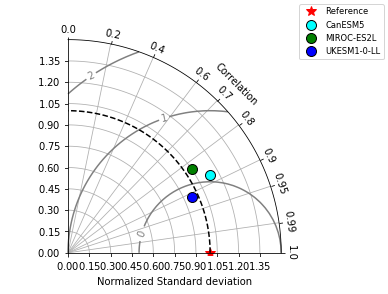

In [81]:
# Reference options 
ref_std = 1
ref_color = 'r'
ref_label = 'Reference'

# Samples list (maybe make a dictionary)
# -----------------------------------
#         std   rho   model  color
# -----------------------------------
#samples = [[stats_dict['std_norm'], stats_dict['corr'],  stats_dict['model'], 'g']]
# samples list is created above

#===============================
# Generate Taylor Diagram
#===============================
fig = plt.figure()

# generate Taylor diagram object 
dia = TaylorDiagram(refstd=ref_std, label=ref_label, extend=False, fig=fig)

# mark reference point as a red star
dia.samplePoints[0].set_color(ref_color)  

# add models to Taylor diagram
for i, (stddev, corrcoef, name, col) in enumerate(samples):
    dia.add_sample(stddev, corrcoef,
                   marker='o', ms=10, ls='',
                   mfc=col, mec='k',
                   label=name)

#===============================
# RMSE contours 
# Levels : number RMSE lines 
# color  : color of contours gray
#===============================
# Add RMS contours, and label them
contours = dia.add_contours(levels=3, colors='0.5') 

# add labelto RMSE contours 
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

# Add grid lines 
dia.add_grid()                              

# Put ticks outward
dia._ax.axis[:].major_ticks.set_tick_out(True)  

# Add a figure legend and title
fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, prop=dict(size='small'), loc='upper right')